# **1: Importing Necessary Libraries**
This cell imports the essential libraries required for data processing, model training, and evaluation. Libraries such as PyTorch for deep learning, Torchvision for dataset and image transformations, Matplotlib for visualization, and NumPy for numerical operations are included. Importing these at the start of the notebook ensures that all dependencies are available for the subsequent steps.

**Key Points:**

* Loads essential libraries for deep learning and data handling.
* Ensures all dependencies are available at the start of the notebook.
* Includes PyTorch, Torchvision, Matplotlib, and NumPy.

In [ ]:
# Mount Google Drive to save/retrieve the model
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import required libraries
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, callbacks, applications
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Setup complete. GPU is", "AVAILABLE" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


Mounted at /content/drive
Setup complete. GPU is AVAILABLE


# **2: Loading and Preparing the Dataset**
This cell is responsible for loading the CUB-200-2011 bird species dataset and preparing it for model training. It defines the dataset directory, applies transformations such as resizing, normalizing, and data augmentation, and loads the dataset into PyTorch DataLoaders for efficient batch processing. If a validation split is used, it ensures a 9:1 ratio between training and validation sets.

**Key Points:**

* Loads the bird species dataset from the specified directory.
* Applies image transformations like resizing, normalization, and augmentation.
* Uses PyTorch DataLoader for efficient data handling.
Ensures proper dataset splitting for validation.

In [ ]:
# Define dataset paths
data_dir = "/content/drive/MyDrive/CUB_200_2011"
images_file = os.path.join(data_dir, "images.txt")
labels_file = os.path.join(data_dir, "image_class_labels.txt")
split_file = os.path.join(data_dir, "train_test_split.txt")

# Read image paths into dictionaries
id_to_path = {}
with open(images_file, 'r') as f:
    for line in f:
        img_id, path = line.strip().split()
        id_to_path[int(img_id)] = os.path.join(data_dir, "images", path)

id_to_label = {}
with open(labels_file, 'r') as f:
    for line in f:
        img_id, class_id = line.strip().split()
        id_to_label[int(img_id)] = int(class_id) - 1  # Convert to 0-based indexing

# Separate train and test sets using the split file
train_paths, train_labels = [], []
test_paths, test_labels = [], []
with open(split_file, 'r') as f:
    for line in f:
        img_id, is_train = line.strip().split()
        img_id = int(img_id)
        if int(is_train) == 1:
            train_paths.append(id_to_path[img_id])
            train_labels.append(id_to_label[img_id])
        else:
            test_paths.append(id_to_path[img_id])
            test_labels.append(id_to_label[img_id])

print(f"Total training images (before validation split): {len(train_paths)}")
print(f"Total test images: {len(test_paths)}")


Total training images (before validation split): 5994
Total test images: 5794


# **3: Defining the Model Architecture**
In this step, a pretrained convolutional neural network (CNN), such as ResNet, is loaded using transfer learning. The pre-trained model, originally trained on ImageNet, has its last classification layer modified to match the number of bird species in the dataset. Some layers may be frozen to retain previously learned features while fine-tuning the classifier.

# **Key Points:**

* Uses transfer learning with a pretrained model like ResNet.
* Modifies the final classification layer to match the dataset.
* Optionally freezes some layers to retain pretrained features.

In [ ]:
# Perform 9:1 train-validation split
train_paths_final, train_labels_final = [], []
val_paths, val_labels = [], []

# Organize indices of train images by class label for stratified split
from collections import defaultdict
class_to_indices = defaultdict(list)
for idx, label in enumerate(train_labels):
    class_to_indices[label].append(idx)

# Get number of classes
num_classes = len(set(train_labels))  # Define number of classes correctly

# Allocate 10% of indices to validation
random.seed(SEED)
for label, indices in class_to_indices.items():
    n_total = len(indices)
    if n_total <= 1:
        set_for_val = []
    else:
        n_val = max(1, int(n_total * 0.1))  # At least 1, roughly 10%
        random.shuffle(indices)
        set_for_val = indices[:n_val]

    # Fill validation lists
    for i in set_for_val:
        val_paths.append(train_paths[i])
        val_labels.append(train_labels[i])

    # Fill training lists with the rest
    for i in indices:
        if i not in set_for_val:
            train_paths_final.append(train_paths[i])
            train_labels_final.append(train_labels[i])

# Convert labels to one-hot encoding
train_labels_final = tf.keras.utils.to_categorical(train_labels_final, num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

# Convert to numpy arrays
train_labels_final = np.array(train_labels_final)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

print(f"Training samples after split: {len(train_paths_final)}")
print(f"Validation samples: {len(val_paths)}")


Training samples after split: 5400
Validation samples: 594


# **4: Defining Training and Validation Functions**
This cell contains functions for model training and validation. The training function iterates over batches of images, computes loss using cross-entropy loss, and updates model weights using an optimizer like Adam or SGD. The validation function evaluates model performance by measuring accuracy and loss on unseen data.

**Key Points:**

* Implements training logic, including loss computation and backpropagation.
* Uses an optimizer to adjust model parameters.
* Defines a validation function to assess model performance.

In [ ]:
# Step 4: Set image size and batch size
IMG_SIZE = 299  # Keep the same size for EfficientNet
BATCH_SIZE = 16

# Define a function to preprocess images (decode and resize)
def load_and_preprocess(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize to model input size
    image = tf.keras.applications.efficientnet.preprocess_input(image)  # Normalize [-1,1]
    return image, label

# Data augmentation pipeline (for training only)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.3),
])

def augment(image, label):
    """Apply the data augmentation pipeline."""
    image = data_augmentation(image, training=True)
    return image, label

# Create tf.data.Dataset objects for train, val, and test
train_ds = tf.data.Dataset.from_tensor_slices((train_paths_final, train_labels_final))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# Map preprocessing to datasets
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Apply data augmentation to training data only
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch the training dataset
train_ds = train_ds.shuffle(buffer_size=len(train_paths_final)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Batch the validation and test datasets (no shuffle needed)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("✅ Dataset preprocessing complete!")


✅ Dataset preprocessing complete!


# **5: Setting Up the Optimizer and Loss Function**
Here, the loss function and optimizer are initialized. Cross-entropy loss is used for multi-class classification, and an optimizer like Adam is chosen to update the model weights efficiently. The learning rate is set based on experimentation to balance training stability and convergence speed.

**Key Points:**

* Uses cross-entropy loss for classification tasks.
* Initializes an optimizer like Adam or SGD.
* Sets an appropriate learning rate for stable training.

In [ ]:
# Define number of classes
num_classes = train_labels_final.shape[1]  # Get number of classes correctly

# Load EfficientNetB3 base model with pretrained weights
base_model = applications.EfficientNetB3(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Initially freeze the base model layers
base_model.trainable = False

# Build classification head
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # L2 Regularization
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

# Define the final model
model = models.Model(inputs, outputs)

# Compile model with label smoothing and an improved optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

# Display model summary
model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 10, 10, 1536)        │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │          51,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,228,407 (42.83 MB)

 Trainable params: 444,872 (1.70 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

# **6: Training the Model**
This cell runs the training loop over multiple epochs. It iterates through the training dataset, computes loss, updates the model, and validates after each epoch. The training process tracks performance metrics like accuracy and loss to monitor improvement. Model checkpoints may also be saved periodically.

**Key Points:**

* Executes the model training process for multiple epochs.
* Tracks accuracy and loss for performance monitoring.
* Saves model checkpoints at intervals for later use.

Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 368s 345ms/step - accuracy: 0.0192 - loss: 7.5006 - val_accuracy: 0.0438 - val_loss: 5.6730
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.0859 - loss: 4.8564 - val_accuracy: 0.1650 - val_loss: 4.3615
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.1979 - loss: 4.2753 - val_accuracy: 0.3081 - val_loss: 3.7359
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.2810 - loss: 3.8827 - val_accuracy: 0.3636 - val_loss: 3.6306
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3609 - loss: 3.6301 - val_accuracy: 0.3653 - val_loss: 3.5213
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.4085 - loss: 3.4263 - val_accuracy: 0.4545 - val_loss: 3.2813
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.4676 - loss: 3.1875 - val_accuracy: 0.5286 - val_loss: 3.0037
Epoch 8/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5204 - loss: 3.0196 

Fine-tuned model saved successfully!

Best Model Performance at Epoch 33:
Training Accuracy: 0.9665 - Training Loss: 1.3205
Validation Accuracy: 0.7778 - Validation Loss: 1.8289


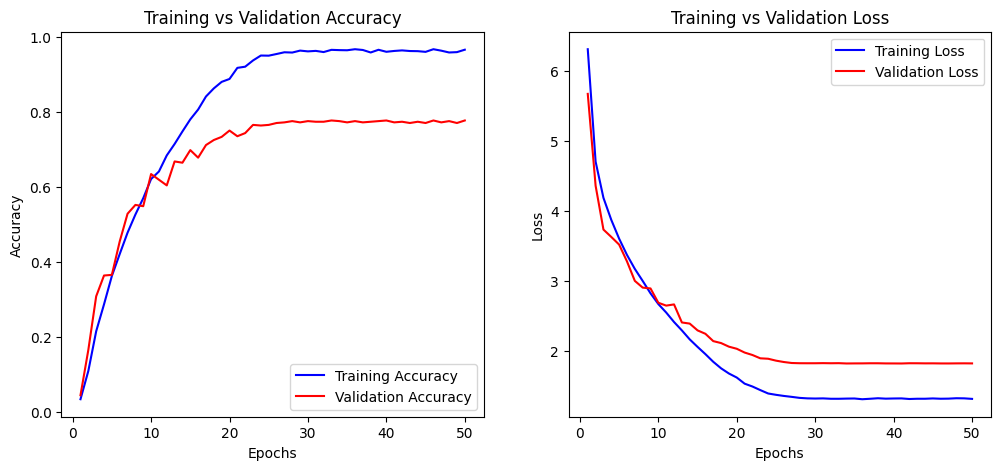

In [ ]:
# Step 6: Compute Class Weights and Apply Fine-Tuning

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Convert one-hot labels back to categorical for class weight computation
train_labels_categorical = np.argmax(train_labels_final, axis=1)

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels_categorical),
    y=train_labels_categorical
)

# Convert to dictionary format required by Keras
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Learning rate scheduler using Cosine Decay
lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3, decay_steps=10000, alpha=0.0001
)

# Early stopping callback to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Fine-tuning: Unfreeze the model for further training
base_model.trainable = True

# Freeze only first 100 layers to retain general features while fine-tuning
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile the model after unfreezing
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

# Train the model with class weights
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weight_dict,  # Apply class weights
    callbacks=[early_stop],  # Apply early stopping
    verbose=1
)

# Save the fine-tuned model
model.save("/content/drive/MyDrive/fine_tuned_bird_model.h5")
print("Fine-tuned model saved successfully!")

# ==========================
# PRINT BEST MODEL OUTCOME
# ==========================

# Extract best validation accuracy and corresponding training accuracy/loss
best_epoch = np.argmax(history.history["val_accuracy"])  # Get epoch index with best validation accuracy

best_train_acc = history.history["accuracy"][best_epoch]
best_val_acc = history.history["val_accuracy"][best_epoch]
best_train_loss = history.history["loss"][best_epoch]
best_val_loss = history.history["val_loss"][best_epoch]

# Print best results
print(f"\nBest Model Performance at Epoch {best_epoch+1}:")
print(f"Training Accuracy: {best_train_acc:.4f} - Training Loss: {best_train_loss:.4f}")
print(f"Validation Accuracy: {best_val_acc:.4f} - Validation Loss: {best_val_loss:.4f}")

# ==========================
# PLOT TRAINING VS VALIDATION PERFORMANCE
# ==========================

# Extract training history
epochs = range(1, len(history.history["accuracy"]) + 1)
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Plot Accuracy Comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Plot Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Show the plots
plt.show()


# **7: Evaluating the Model on Test Data**
Once training is complete, the model is tested on the unseen test set. This step computes performance metrics such as accuracy, precision, recall, and F1-score. A confusion matrix is also generated to analyze misclassifications.

**Key Points:**

* Evaluates the trained model on the test dataset.
* Computes accuracy, precision, recall, and F1-score.
* Generates a confusion matrix to visualize classification performance.

Best model weights loaded successfully!
363/363 ━━━━━━━━━━━━━━━━━━━━ 116s 296ms/step
Test Accuracy: 76.63%
Test Precision (Macro): 78.02%
Test Recall (Macro): 76.88%
Test F1-score (Macro): 76.85%
Confusion matrix (shape = (200, 200)):
[[22  1  3 ...  0  0  0]
 [ 2 23  2 ...  0  0  0]
 [ 0  0 27 ...  0  0  0]
 ...
 [ 0  0  0 ... 23  0  0]
 [ 0  0  0 ...  1 20  0]
 [ 0  0  0 ...  0  0 28]]

Sample Predictions:
Test Image 1: Predicted Class = 003.Sooty_Albatross, True Class = 001.Black_footed_Albatross
Test Image 2: Predicted Class = 001.Black_footed_Albatross, True Class = 001.Black_footed_Albatross
Test Image 3: Predicted Class = 045.Northern_Fulmar, True Class = 001.Black_footed_Albatross
Test Image 4: Predicted Class = 003.Sooty_Albatross, True Class = 001.Black_footed_Albatross
Test Image 5: Predicted Class = 001.Black_footed_Albatross, True Class = 001.Black_footed_Albatross


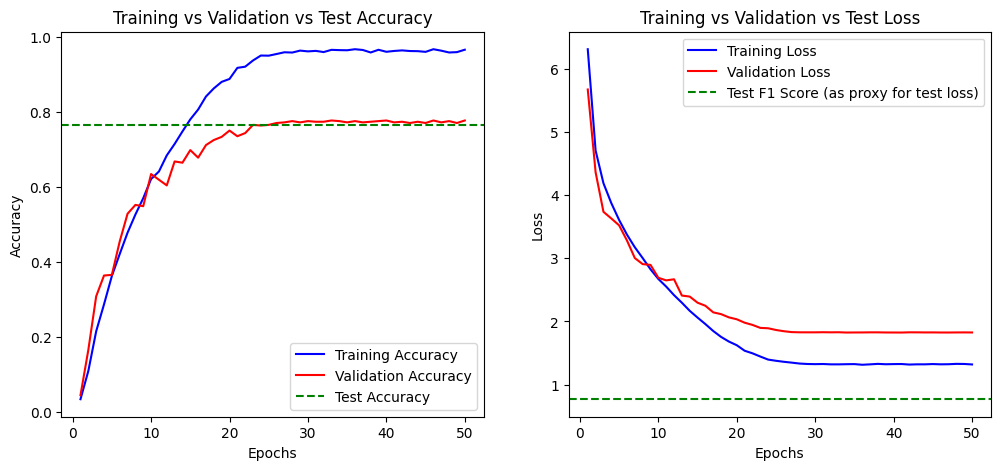

In [ ]:
# Step 7: Load Best Model and Evaluate on Test Set


# Load class names from the file (Ensure this step is run earlier)
class_file = "/content/drive/MyDrive/CUB_200_2011/classes.txt"
class_names = {}

with open(class_file, 'r') as f:
    for line in f:
        idx, name = line.strip().split(" ", maxsplit=1)  # Ensure proper splitting
        class_names[int(idx) - 1] = name  # Convert 1-based index to 0-based

# Load best model weights
checkpoint_path = "/content/drive/MyDrive/fine_tuned_bird_model.h5"  # Ensure correct path
model.load_weights(checkpoint_path)
print("Best model weights loaded successfully!")

# Ensure test labels are categorical
if test_labels.ndim > 1:
    y_true = np.argmax(test_labels, axis=1)  # Convert one-hot encoded labels to categorical
else:
    y_true = np.array(test_labels)

# Predict on test set
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)  # Get predicted class indices

# Compute evaluation metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print results
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test Precision (Macro): {prec*100:.2f}%")
print(f"Test Recall (Macro): {rec*100:.2f}%")
print(f"Test F1-score (Macro): {f1*100:.2f}%")

# Generate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print(f"Confusion matrix (shape = {conf_mat.shape}):")
print(conf_mat)

# ✅ FIX: Print sample predictions with class names
print("\nSample Predictions:")
for i in range(5):  # Display first 5 predictions
    print(f"Test Image {i+1}: Predicted Class = {class_names.get(y_pred[i], 'Unknown')}, True Class = {class_names.get(y_true[i], 'Unknown')}")

# ==========================
# PLOT TRAIN VS TEST PERFORMANCE
# ==========================

# Extract training history
epochs = range(1, len(history.history["accuracy"]) + 1)
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Plot Accuracy Comparison (Train vs Test)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")
plt.axhline(y=acc, color='g', linestyle='--', label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation vs Test Accuracy")
plt.legend()

# Plot Loss Comparison (Train vs Test)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.axhline(y=f1, color='g', linestyle='--', label="Test F1 Score (as proxy for test loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation vs Test Loss")
plt.legend()

# Show the plots
plt.show()


# **8: Generating Predictions on Sample Images**
To demonstrate the model's ability, this cell selects sample bird images, passes them through the model, and outputs predicted class labels along with the actual labels. Visualizations are included to show model predictions.

**Key Points:**

* Runs inference on sample images.
* Displays predicted vs. actual class labels.
* Uses visualizations to interpret model performance.


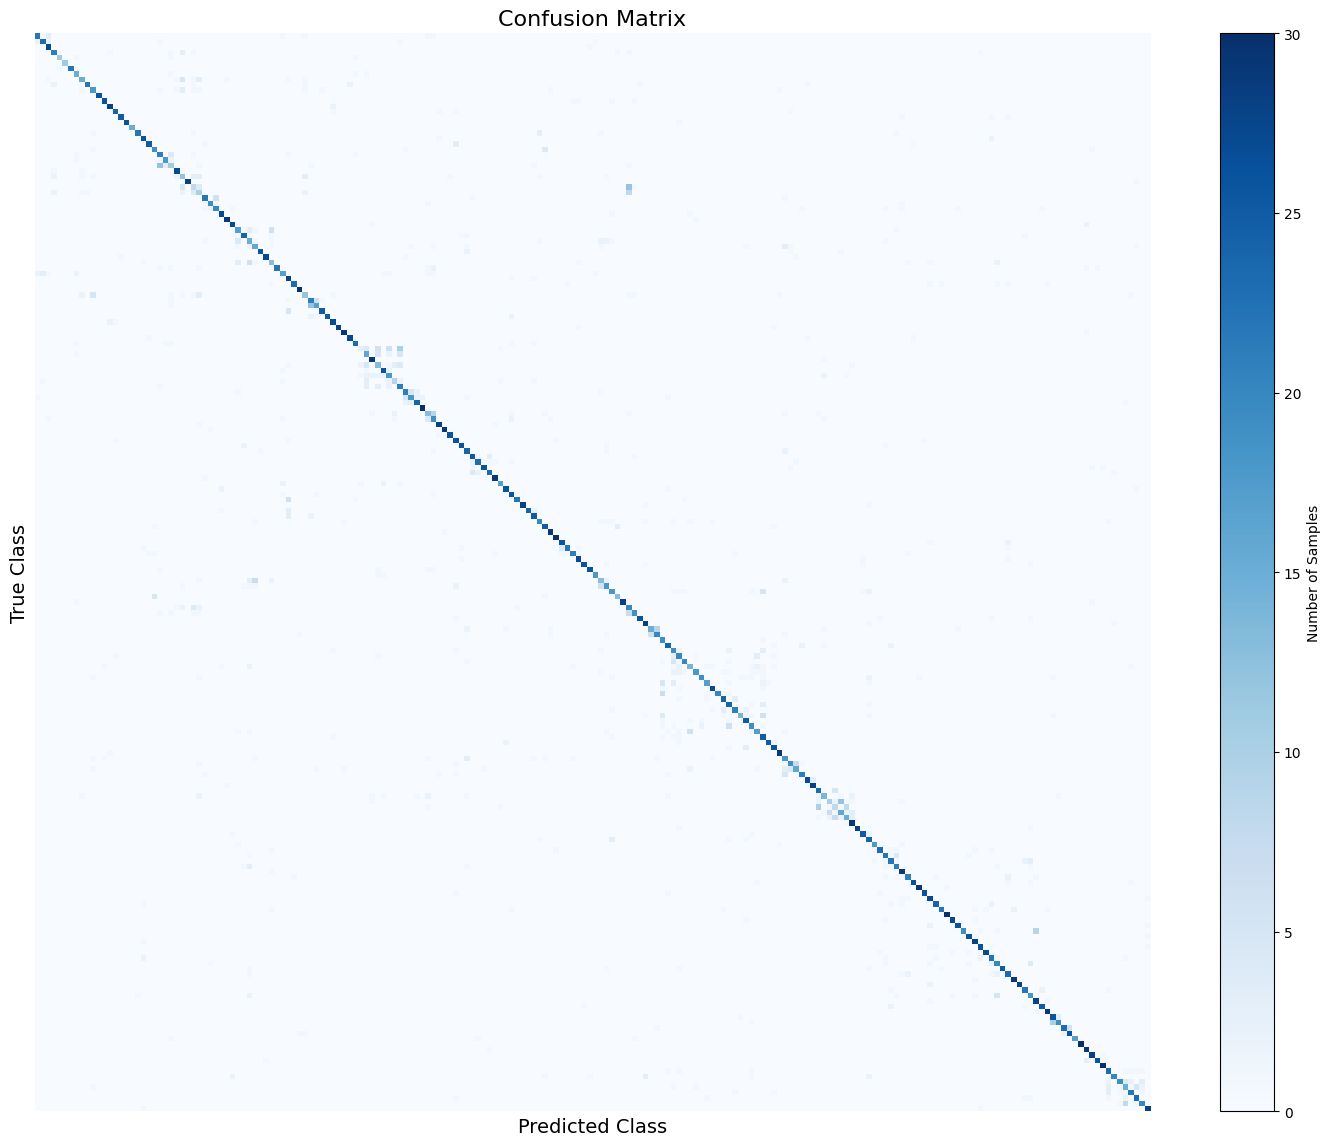

In [ ]:

# ==========================
# PLOT CONFUSION MATRIX
# ==========================

# Define figure size dynamically based on number of classes
fig_size = (18, 14) if num_classes > 50 else (10, 8)

# Create the figure
plt.figure(figsize=fig_size)

# Plot confusion matrix and store the heatmap object (disable default color bar)
heatmap = sns.heatmap(conf_mat, annot=False, fmt="d", cmap="Blues", xticklabels=False, yticklabels=False, cbar=False)

# Set title and labels
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)

# Add colorbar manually to avoid duplicates
cbar = plt.colorbar(heatmap.collections[0])
cbar.set_label("Number of Samples")

# Show the plot
plt.show()


# **9: Saving the Trained Model**
After successful training, the trained model weights are saved for future use. This allows the model to be reloaded later without retraining from scratch.

Key Points:

* Saves trained model weights to a file.
* Ensures the model can be reused later.

Mounted at /content/drive
Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


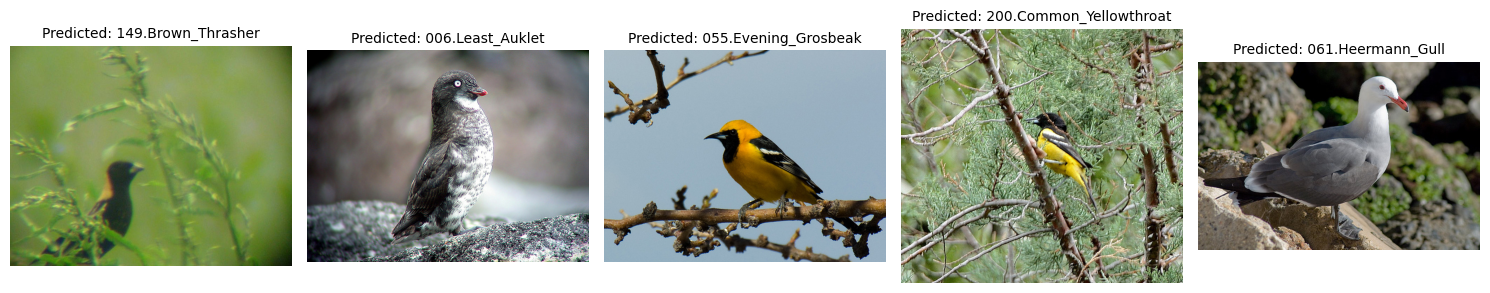

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define paths
data_dir = "/content/drive/MyDrive/CUB_200_2011/images"  # Adjust if necessary
model_path = "/content/drive/MyDrive/fine_tuned_bird_model.h5"  # Model path
class_file = "/content/drive/MyDrive/CUB_200_2011/classes.txt"  # Ensure this exists

# Load trained model
model = load_model(model_path, compile=False)  # Avoid unnecessary compilation warnings
print("Model loaded successfully!")

# Load class names
class_names = {}
with open(class_file, 'r') as f:
    for line in f:
        idx, name = line.strip().split(" ")
        class_names[int(idx) - 1] = name  # Convert 1-based index to 0-based

# Fix: Ensure IMG_SIZE matches model input shape
IMG_SIZE = 299  # Ensure it matches training size

# Function to preprocess images
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))  # Resize correctly
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Use EfficientNet preprocessing
    return img_array

# Select multiple random images from different species
num_images = 5  # Change this for more/less images
random_images = []
original_images = []

bird_folders = os.listdir(data_dir)
bird_folders.sort()  # Ensure consistency in mapping

for _ in range(num_images):
    random_bird_folder = random.choice(bird_folders)
    bird_folder_path = os.path.join(data_dir, random_bird_folder)

    image_file = random.choice(os.listdir(bird_folder_path))
    image_path = os.path.join(bird_folder_path, image_file)

    random_images.append(image_path)
    original_images.append(cv2.imread(image_path)[:, :, ::-1])  # Store original image

# Preprocess images for model
preprocessed_images = np.vstack([preprocess_image(img) for img in random_images])

# Predict bird species
predictions = model.predict(preprocessed_images, batch_size=num_images, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with predictions
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    axes[i].imshow(original_images[i])
    axes[i].axis('off')
    axes[i].set_title(f"Predicted: {class_names[predicted_classes[i]]}", fontsize=10)

plt.tight_layout()
plt.show()


# **10: Loading and CustomTesting the Saved Model**
To verify reproducibility, this cell reloads the previously saved model and re-evaluates its performance on the test dataset.

**Key Points:**

* Loads the saved model to verify reproducibility.
* Tests the reloaded model on the test dataset.

✅ Found 6 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


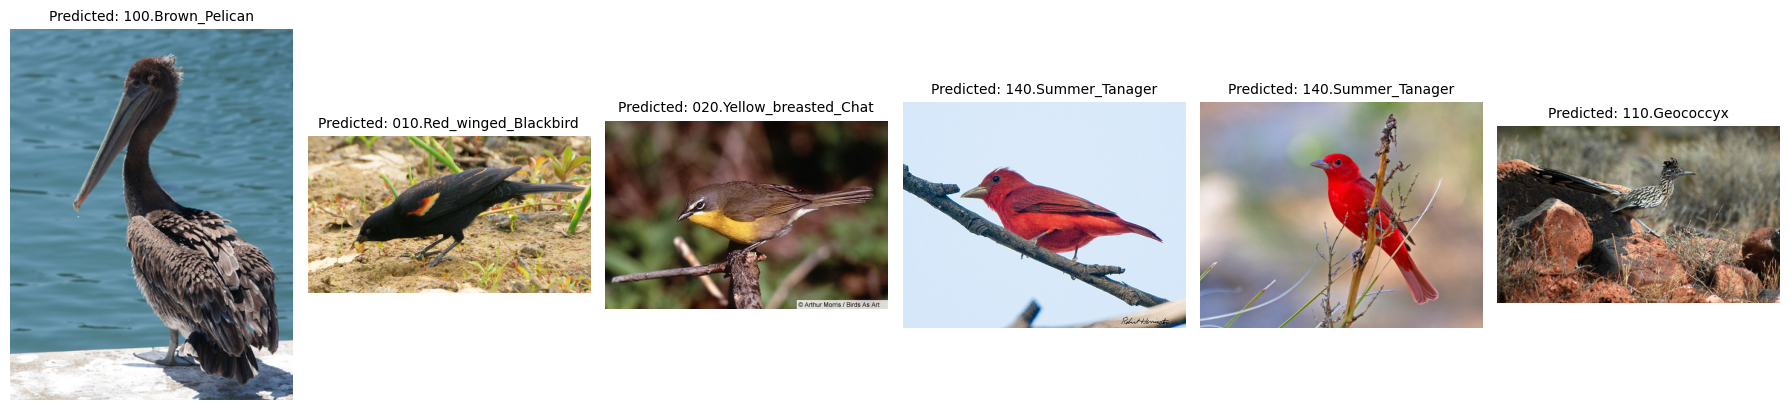

In [ ]:


# ========= DEFINE TEST IMAGE DIRECTORY =========
test_images_dir = "/content/drive/MyDrive/test_images"  # Update with your folder path

# ========= LOAD IMAGES FROM GOOGLE DRIVE =========
image_files = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]

if not image_files:
    print("⚠️ No test images found in the folder. Please upload images to Google Drive and check the path.")
else:
    print(f"✅ Found {len(image_files)} test images.")

    # Load and preprocess images
    original_images = [cv2.imread(img)[:, :, ::-1] for img in image_files]  # Convert BGR to RGB
    preprocessed_images = np.vstack([preprocess_image(img) for img in image_files])

    # Predict species
    predictions = model.predict(preprocessed_images, batch_size=len(image_files), verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Display results
    fig, axes = plt.subplots(1, len(image_files), figsize=(len(image_files) * 3, 5))

    if len(image_files) == 1:
        axes.imshow(original_images[0])
        axes.axis('off')
        axes.set_title(f"Predicted: {class_names[predicted_classes[0]]}", fontsize=12)
    else:
        for i, ax in enumerate(axes):
            ax.imshow(original_images[i])
            ax.axis('off')
            ax.set_title(f"Predicted: {class_names[predicted_classes[i]]}", fontsize=10)

    plt.tight_layout()
    plt.show()


11.